In [1]:
import tensorflow as tf
from functions import *

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))



2024-03-15 01:04:55.047792: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-15 01:04:55.081984: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 01:04:55.706406: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  0


2024-03-15 01:04:58.034328: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-03-15 01:04:58.034350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: utkarh-nitro5
2024-03-15 01:04:58.034353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: utkarh-nitro5
2024-03-15 01:04:58.034422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 550.54.14
2024-03-15 01:04:58.034433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 550.54.14
2024-03-15 01:04:58.034435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 550.54.14


In [2]:
import gc
gc.collect()


0

In [3]:
from tensorflow.keras.backend import clear_session
clear_session()


In [4]:
import hyperparameters as hp


directory_path = 'LA/ASVspoof2019_LA_train/flac'

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

def se_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Conv2D(filters // ratio, 1, activation='relu')(se)
    se = layers.Conv2D(filters, 1, activation='sigmoid')(se)
    return layers.Multiply()([input_tensor, se])

def mb_conv1_block(input_tensor, kernel_size=3, filters=16, dropout_rate=0.2):
    x = layers.Conv2D(filters, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = se_block(x)
    x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    return layers.Add()([x, input_tensor])

def mb_conv6_block(input_tensor, kernel_size=3, filters=16, dropout_rate=0.2):
    input_filters = input_tensor.shape[-1]
    if input_filters != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = layers.Conv2D(filters * 6, (1, 1), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.DepthwiseConv2D((kernel_size, kernel_size), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = se_block(x)
    x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    return layers.Add()([x, shortcut])

def BasicBlock(input_tensor, c_in, c_out):
    x = layers.Conv2D(c_out, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(c_out, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

def attention_branch(input_tensor):
    x = BasicBlock(input_tensor, 1, 2)
    x = BasicBlock(x, 2, 4)
    x = BasicBlock(x, 4, 8)
    x = BasicBlock(x, 8, 16)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(16, (1, 1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(1, (1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    A = layers.Activation('sigmoid')(x)
    return A

def EfficientNet_A0_with_attention(input_shape=(1, hp.F, hp.T), dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (1, 1), padding='same')(inputs)
    x = mb_conv1_block(x, filters=32, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=32, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=48, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=48, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=64, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=64, dropout_rate=dropout_rate)
    x = layers.Conv2D(1280, (1, 1), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    R = layers.GlobalAveragePooling2D()(x)
    R_output = layers.Dense(1, activation='sigmoid')(R)
    A = attention_branch(inputs)
    A_adjusted = layers.GlobalAveragePooling2D()(A)
    A_adjusted = layers.Reshape((1,))(A_adjusted)
    combined_output = R_output + R_output * A_adjusted
    model = models.Model(inputs, combined_output)
    return model

# shape: (1xFxT)
input_shape = (1, hp.F, hp.T)
model = EfficientNet_A0_with_attention(input_shape=input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 50, 50)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 1, 50, 32)    1632        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1, 50, 32)    9248        ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 1, 50, 32)   128         ['conv2d_1[0][0]']               
 alization)                                                                                   

In [6]:
import os
import tensorflow as tf

with open('train_preprocessed.txt', 'r') as file:
    data = file.readlines()

file_names = []
labels = []


for line in data:
    file_name, label = line.split()
    file_names.append(file_name)
    labels.append(int(label))

tensors = []

for file_name in file_names:
    file_path = os.path.join(directory_path, file_name)
    signal, sample_rate = read_flac_file(file_path)
    lfcc_features = extract_lfcc(signal, sample_rate)
    tensor = tf.convert_to_tensor(lfcc_features)
    tensor = tf.expand_dims(tensor, axis=0)
    tensors.append(tensor)

labels = tf.convert_to_tensor(labels)

dataset = tf.data.Dataset.from_tensor_slices((tensors, labels))

dataset = dataset.shuffle(buffer_size=len(tensors)).batch(32)


In [7]:
labels

<tf.Tensor: shape=(25380,), dtype=int32, numpy=array([1, 1, 1, ..., 0, 0, 0], dtype=int32)>

In [8]:
# # now use the files in the validation set to evaluate the model , location of the validation set is 'val_preprocessed.txt'

# with open('val_preprocessed.txt', 'r') as file:
#     data = file.readlines()
    
# file_names_val = []
# labels_val = []

# subset_size = 100
# for line in data:
#     if subset_size == 0:
#         break
#    # subset_size -= 1
#     file_name, label = line.split()
#     labels_val.append(int(label))
#     file_names_val.append(file_name)

# tensors_val = []

# directory_path = 'LA/ASVspoof2019_LA_eval/flac'

# for file_name in file_names_val:
#     file_path = os.path.join(directory_path, file_name)
#     signal, sample_rate = read_flac_file(file_path)
#     lfcc_features = extract_lfcc(signal, sample_rate)
#     tensor = tf.convert_to_tensor(lfcc_features)
#     tensor = tf.expand_dims(tensor, axis=0)
#     tensors_val.append(tensor)


# labels_val = tf.convert_to_tensor(labels_val)

# dataset_val = tf.data.Dataset.from_tensor_slices((tensors_val, labels_val))

# dataset_val = dataset_val.shuffle(buffer_size=len(tensors_val)).batch(32)


def data_generator(file_names, labels, directory_path):
    for file_name, label in zip(file_names, labels):
        file_path = os.path.join(directory_path, file_name)
        signal, sample_rate = read_flac_file(file_path)
        lfcc_features = extract_lfcc(signal, sample_rate)
        tensor = tf.convert_to_tensor(lfcc_features, dtype=tf.float32)
        tensor = tf.expand_dims(tensor, axis=0)  # Add batch dimension
        tensor = tf.expand_dims(tensor, axis=-1)  # Add channel dimension
        yield tensor, label

# Reading data from the validation set
with open('val_preprocessed.txt', 'r') as file:
    data = file.readlines()

file_names_val = []
labels_val = []
# subset_size = 150  # Adjust if you're using a subset

for line in data:
    file_name, label = line.strip().split()
    labels_val.append(int(label))
    file_names_val.append(file_name)

directory_path = 'LA/ASVspoof2019_LA_eval/flac'

# Create a dataset from the generator
dataset_val = tf.data.Dataset.from_generator(
    lambda: data_generator(file_names_val, labels_val, directory_path),  # Removed batch_size=32
    output_types=(tf.float32, tf.int32),
    output_shapes=((1, hp.F, hp.T, 1), ())
)

# Shuffle and batch the dataset
dataset_val = dataset_val.shuffle(buffer_size=len(file_names_val)).batch(32)



In [9]:
labels_val

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [10]:

model.fit(dataset, epochs=10)



# save the model as pkl 

model.save('model.keras')



Epoch 1/10


2024-03-15 01:07:09.353970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [25380]
	 [[{{node Placeholder/_1}}]]
2024-03-15 01:07:09.354253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [25380]
	 [[{{node Placeholder/_1}}]]


794/794 [==============================] - 34s 37ms/step - loss: 1.5393 - accuracy: 0.8217
Epoch 2/10
794/794 [==============================] - 27s 34ms/step - loss: 0.2673 - accuracy: 0.9113
Epoch 3/10
794/794 [==============================] - 28s 35ms/step - loss: 0.3427 - accuracy: 0.8966
Epoch 4/10
794/794 [==============================] - 27s 34ms/step - loss: 0.2972 - accuracy: 0.9050
Epoch 5/10
794/794 [==============================] - 29s 36ms/step - loss: 0.2261 - accuracy: 0.9166
Epoch 6/10
794/794 [==============================] - 29s 37ms/step - loss: 0.2214 - accuracy: 0.9217
Epoch 7/10
794/794 [==============================] - 27s 34ms/step - loss: 0.2725 - accuracy: 0.9155
Epoch 8/10
794/794 [==============================] - 28s 35ms/step - loss: 0.2295 - accuracy: 0.9160
Epoch 9/10
794/794 [==============================] - 28s 35ms/step - loss: 0.2357 - accuracy: 0.9178
Epoch 10/10
794/794 [==============================] - 27s 35ms/step - loss: 0.2510 - accurac

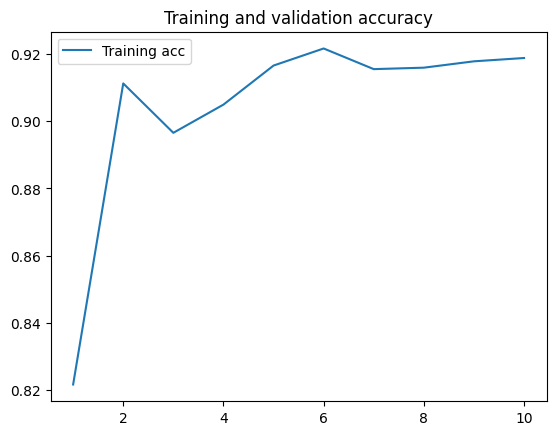

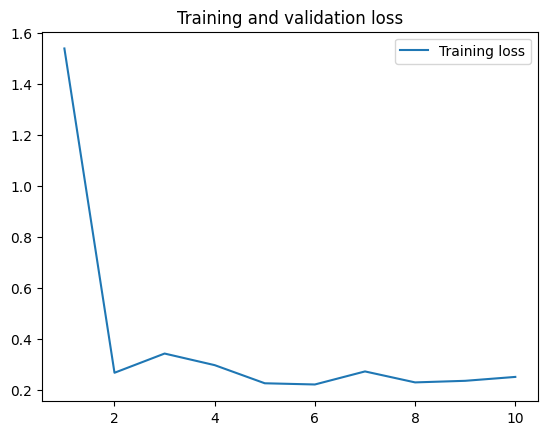

In [11]:
def plot_history(history):
    import matplotlib.pyplot as plt
    
    acc = history.history['accuracy']
    # val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    # val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='Training acc')
    # plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    # plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(model.history)

In [12]:
# load model from pkl

# model = tf.keras.models.load_model('model.keras')


# model.evaluate(dataset_val)
# predictions = model.predict(dataset_val)

In [13]:
print("TRAINING OF THE MODEL IS DONE!")

TRAINING OF THE MODEL IS DONE!
